# TITANIC DATASET EDA AND ML MODEL 

In [1]:
# importing libraries required to read the data
import os
from zipfile import ZipFile

#importing libaries required for EDA
import pandas as pd
import numpy as np

#importing libaries for data visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#importing libaries for data preparation and pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

#importing libaries for ML modeling
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

#importing libaries for model performance validation
from sklearn import metrics
from sklearn.model_selection import cross_val_score, cross_val_predict


In [2]:
#setting up env to download data from Kaggle
os.environ['KAGGLE_CONFIG_DIR'] =  os.getcwd()
!kaggle competitions download -c titanic

titanic.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
def zip_file_extraction(folders = ['dataset'], file_path = os.getcwd()):
    """
    This Fuction will take input of foldername (default 'dataset')as list.
    folder path (default 'currect dir')
    
    """
    for folder in folders:
        folder_path = os.path.join(file_path,folder)
        if not os.path.exists(folder_path):
            os.mkdir(folder)
        else:
            print('Folder already present')
    folder_path = os.path.join(file_path,'dataset')
    for file in os.listdir(file_path):
        if file.endswith('.zip'):
            with ZipFile(file) as zobj:
                zobj.extractall(folder_path)

In [4]:
zip_file_extraction(folders=['dataset', 'submission'])

Folder already present
Folder already present


## DATA READING AND ANALYSIS

In [5]:
titanic = pd.read_csv('./dataset/train.csv')

In [6]:
titanic.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
329,330,1,1,"Hippach, Miss. Jean Gertrude",female,16.0,0,1,111361,57.9792,B18,C
809,810,1,1,"Chambers, Mrs. Norman Campbell (Bertha Griggs)",female,33.0,1,0,113806,53.1000,E8,S
229,230,0,3,"Lefebre, Miss. Mathilde",female,NaN,3,1,4133,25.4667,NaN,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
782,783,0,1,"Long, Mr. Milton Clyde",male,29.0,0,0,113501,30.0000,D6,S


In [7]:
titanic.shape

(891, 12)

In [8]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


- Survided got a Negative Corr with Pclass, age, SibSp
- that means that passenger staying in lower class chances of survival is less.
- if age is more than chances of survival is also less.
- Passenger with spouse have lesser chance of survival
- But if you got childern (Parch) passenger got higher chance of survival
- Fare got positive corr with survided that means higher class passenger got hogh posbility of survival. Which supports the negative corr with Pclass


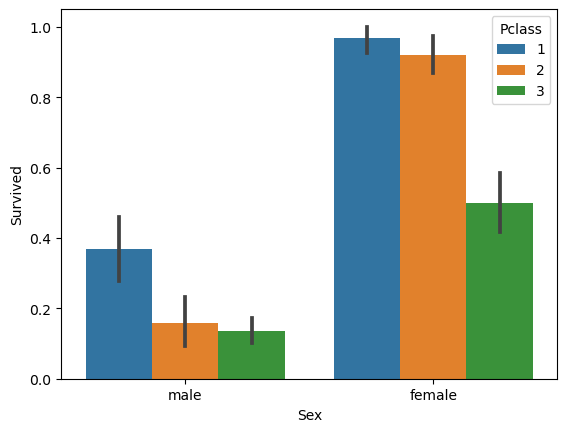

In [9]:
#plotting bar graph survived, sex in every class
sns.barplot(x=titanic['Sex'], y=titanic['Survived'], hue = titanic['Pclass']); 

- Above graph shows that 1st class passengers were saved more than the 3rd class passenger.
- Above graph shows that irrespective of class female passengers were saved more.
- Need to check class wise sex distribution. 

In [10]:
#grupoby dataframe on Pclass, age
titanic_groupby_class_sex = titanic.groupby(['Pclass','Sex', 'Survived']).agg({ 'Age' : 'mean', 'Name' : 'count'}).reset_index()
titanic_groupby_class_sex.rename(columns={'Name' : 'Count', 'Age' : 'Avg_Age'},inplace= True)
titanic_groupby_class_sex['Sex_pct'] = (titanic_groupby_class_sex['Count']/titanic_groupby_class_sex['Count'].sum())*100

In [11]:
titanic_groupby_class_sex

,Pclass,Sex,Survived,Avg_Age,Count,Sex_pct
0,1,female,0,25.666667,3,0.336700
1,1,female,1,34.939024,91,10.213244
2,1,male,0,44.581967,77,8.641975
3,1,male,1,36.248000,45,5.050505
4,2,female,0,36.000000,6,0.673401
5,2,female,1,28.080882,70,7.856341
6,2,male,0,33.369048,91,10.213244
7,2,male,1,16.022000,17,1.907969
8,3,female,0,23.818182,72,8.080808
9,3,female,1,19.329787,72,8.080808


- Maximum number of woman were travling in first and 2nd class
- 50-50 death and survive in women in 3rd class.
- Maximum passenger were travelling in 3rd clas.

<Axes: xlabel='Pclass', ylabel='Sex_pct'>

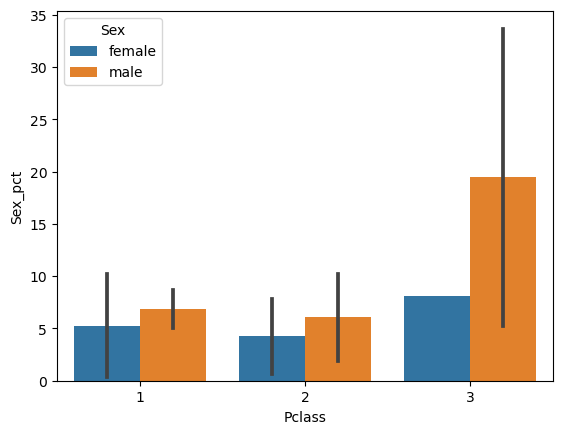

In [12]:
#bar plot to chcek class wise sex count
sns.barplot(x = titanic_groupby_class_sex['Pclass'], y= titanic_groupby_class_sex['Sex_pct'],
            hue = titanic_groupby_class_sex['Sex'])

<Axes: xlabel='Sex', ylabel='Sex_pct'>

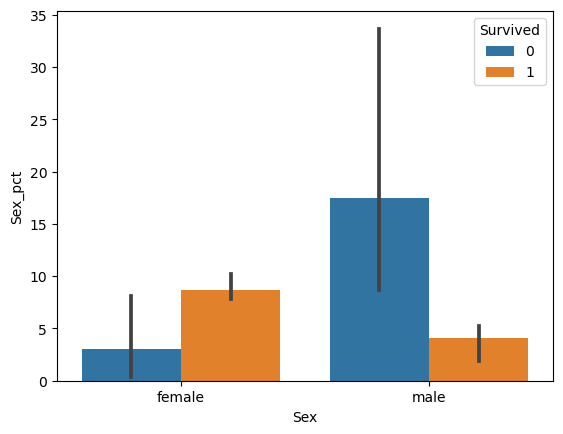

In [13]:
#bar plot between Sex, count and Survived
sns.barplot(x = titanic_groupby_class_sex['Sex'], y= titanic_groupby_class_sex['Sex_pct'],
            hue = titanic_groupby_class_sex['Survived'])

<Axes: xlabel='Survived', ylabel='Age'>

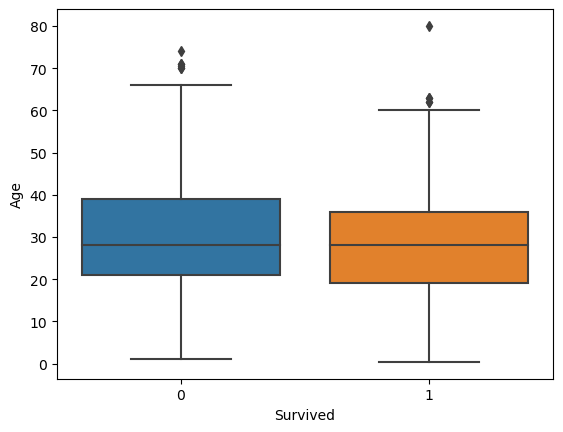

In [14]:
#box plot bewteen Survived and age,

sns.boxplot(data=titanic, x='Survived', y ='Age')

- Above graph shows that there is some outliers in male and female
- Higher the age lesse the chance of Survival


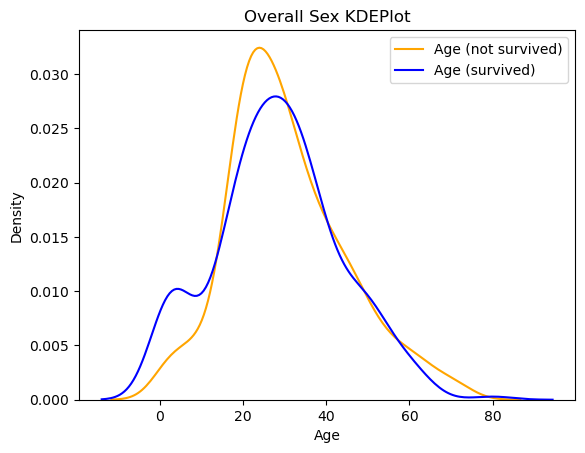

In [15]:
#kdeplot for the age
fig, ax1 = plt.subplots()
data = titanic[titanic['Survived'] == 0]
data1= titanic[titanic['Survived'] == 1]
sns.kdeplot(data = data, x = 'Age', ax=ax1, label = 'Age (not survived)' ,color= 'Orange' )
#kdeplot for age and surviced
sns.kdeplot(data = data1, x = 'Age', ax=ax1, label = 'Age (survived)',color= 'Blue')

plt.title('Overall Sex KDEPlot')
plt.legend()
plt.show()


- Probability of survival is lower that not survival in the age between 20 to 40
- Probability of survival is high in case age is bewlo 20
- For age more than 40 survival probsbility is more than the not survival

**Need to check for Sexwise and classwiese distribution to understand why more than 40 got slight higher chance of survival**

Text(0.5, 1.0, 'Survived')

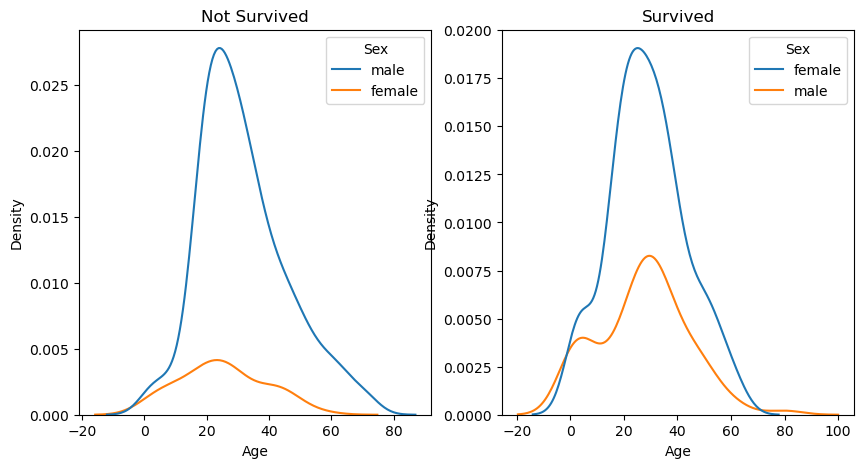

In [16]:
#kde plot with sex as hue
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
sns.kdeplot(data = data, x = 'Age', hue = 'Sex', ax=ax1, color= 'Orange')
ax1.set_title('Not Survived')
#kdeplot for age and surviced
sns.kdeplot(data = data1, x = 'Age', hue = 'Sex', ax=ax2, color= 'Orange' )
ax2.set_title('Survived')

- Above graph shows that above 30 not survival goes down and survival is increased.


Text(0.5, 1.0, 'Survived')

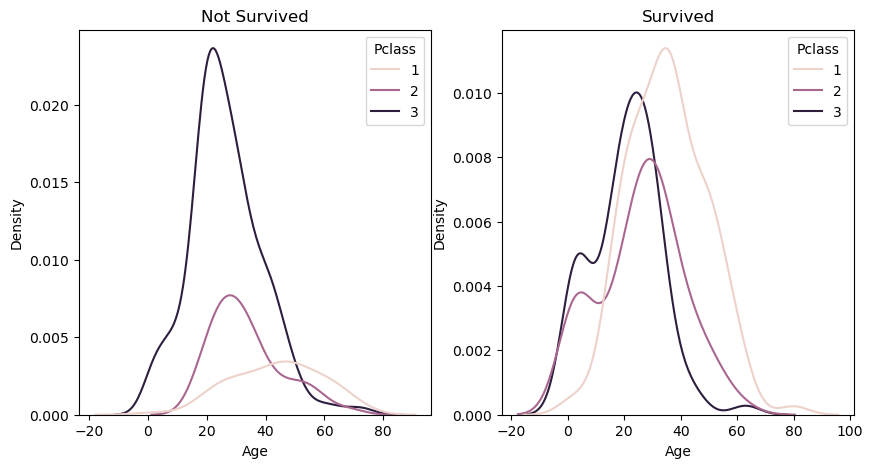

In [17]:
#kde plot with Pclass as hue
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
sns.kdeplot(data = data, x = 'Age', hue = 'Pclass', ax=ax1, color= 'Orange')
ax1.set_title('Not Survived')
#kdeplot for age and surviced
sns.kdeplot(data = data1, x = 'Age', hue = 'Pclass', ax=ax2 ,color= 'Orange' )
ax2.set_title('Survived')

### From above analysis it is noted that Sex, Age and Pclass are the most important factor for Survival. We will use stratified shuffle split in order to get the Sex and Class with same ratio of distribution

In [18]:
# train test split using StratifiedShuffleSplit
titanic_df = titanic[['Age', 'Sex', 'Pclass', 'Survived']]
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits = 1, test_size = .2, random_state = 42)
for train_index, test_index in split.split(titanic_df,titanic_df[['Sex', 'Pclass']]):
    X_train, X_test = titanic_df.drop('Survived', axis = 1).iloc[train_index], titanic_df.drop('Survived', axis = 1).iloc[test_index]
    y_train, y_test = titanic_df['Survived'].iloc[train_index], titanic_df['Survived'].iloc[test_index]


In [19]:
print(X_train.shape)
print(titanic.shape)

(712, 3)
(891, 12)


In [20]:
(X_train['Sex'].value_counts()/X_train.shape[0])*100

male      64.747191
female    35.252809
Name: Sex, dtype: float64

In [21]:
(titanic['Sex'].value_counts()/titanic.shape[0])*100

male      64.758698
female    35.241302
Name: Sex, dtype: float64

In [22]:
X_train_num = X_train.drop('Sex', axis = 1)

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([ 
                        ('impute', SimpleImputer(strategy = "median")),
                        ('std_scaler', StandardScaler())
                ])
titanic_num_pipe = num_pipeline.fit_transform(X_train_num)

In [24]:
titanic_num_pipe

array([[ 0.48467326, -1.56405658],
       [ 2.43622768, -1.56405658],
       [ 0.93503197, -0.36791449],
       ...,
       [-0.11580502,  0.8282276 ],
       [-0.41604416, -0.36791449],
       [ 1.38539069,  0.8282276 ]])

In [25]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

def dataprep (df):
    """
    Fuction will take input of a dataframe segregate categorical columns 
    and number columns and prepare the data for model training
    """
    
    df_num = df.drop('Sex', axis = 1)
    num_attribs = list (df_num)
    cat_attribute = ['Sex']

    full_pipeline = ColumnTransformer ([
        ("num",num_pipeline, num_attribs),
        ("cat",OneHotEncoder(),cat_attribute)
    ])
    
    df_prepared = full_pipeline.fit_transform(df)
    return df_prepared
    
X_train_prepared = dataprep(X_train)
X_test_prepared = dataprep(X_test)

In [26]:
X_train_prepared

array([[ 0.48467326, -1.56405658,  1.        ,  0.        ],
       [ 2.43622768, -1.56405658,  0.        ,  1.        ],
       [ 0.93503197, -0.36791449,  0.        ,  1.        ],
       ...,
       [-0.11580502,  0.8282276 ,  0.        ,  1.        ],
       [-0.41604416, -0.36791449,  1.        ,  0.        ],
       [ 1.38539069,  0.8282276 ,  1.        ,  0.        ]])

## Using Random forest Classifier

In [27]:
# creating a RF classifier
clf = RandomForestClassifier(n_estimators = 100) 

clf.fit(X_train_prepared, y_train)
y_pred = clf.predict(X_test_prepared)

In [28]:
print('Accurecy of the model is:  ', metrics.accuracy_score(y_test, y_pred))

Accurecy of the model is:   0.776536312849162


# USing corss val score

In [29]:
scores = cross_val_score(clf, X_train_prepared, y_train,
                         scoring="accuracy", cv=10)
scores

array([0.875     , 0.84722222, 0.76056338, 0.87323944, 0.81690141,
       0.8028169 , 0.83098592, 0.78873239, 0.83098592, 0.84507042])

In [30]:
y_pred = cross_val_predict(clf, X_test_prepared, y_test, cv=10)

In [31]:
confusion_metric = metrics.confusion_matrix(y_test, y_pred)
confusion_metric

array([[92, 17],
       [30, 40]], dtype=int64)

<Axes: >

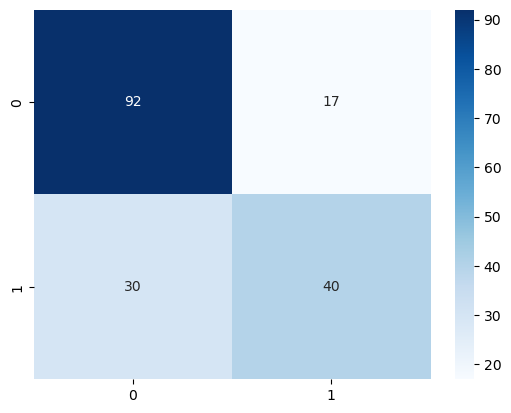

In [32]:
sns.heatmap(confusion_metric, annot= True, cmap= 'Blues')

## Using complete training data for model training

In [33]:
#using complete training data for training

X_train_df = titanic[['Age', 'Sex', 'Pclass']]
Y_train_df = titanic['Survived']
    
X_train_prepared = dataprep(X_train_df)

In [34]:
scores = cross_val_score(clf, X_train_prepared, Y_train_df,
                         scoring="accuracy", cv=10)
scores

array([0.76666667, 0.80898876, 0.7752809 , 0.84269663, 0.84269663,
       0.82022472, 0.83146067, 0.80898876, 0.85393258, 0.79775281])

### Using complete test data for predction

In [35]:
titanic_test = pd.read_csv('./dataset/test.csv')
titanic_survived = pd.read_csv('./dataset/gender_submission.csv')

In [36]:
titanic_test = titanic_test.merge(titanic_survived, on = ['PassengerId'])

In [37]:
titanic_df_test = titanic_test[['Age', 'Sex', 'Pclass']]
titanic_test_result = titanic_test['Survived']

In [38]:
X_test_prepared = dataprep(titanic_df_test)

In [39]:
y_pred = clf.predict(X_test_prepared)

In [40]:
confusion_metric = metrics.confusion_matrix(titanic_test_result, y_pred)
print(confusion_metric)
print(print('Accurecy of the model is:  ', metrics.accuracy_score(titanic_test_result, y_pred)))

[[176  90]
 [ 18 134]]
Accurecy of the model is:   0.7416267942583732
None


<Axes: >

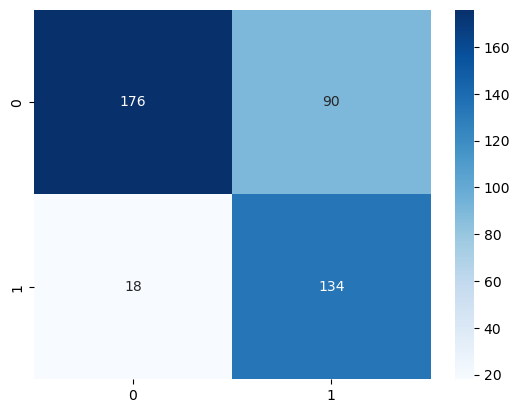

In [41]:
sns.heatmap(confusion_metric, annot= True, cmap= 'Blues', fmt='g')

## Above model shows very poor accurecy and performance. Now we will check for each column and analyze the data. Basis analysis we will prepare the features

### Removing outliers from age column

In [42]:
def outliers(titanic, params:[]):
    """
    This fuction will detect and remove the outliers where it is more than Q3 and less than Q1 by 1.5times of IQR.

    """
    titanic_copy = titanic.copy()
    for param in params:
        Q1 = titanic_copy[param].quantile(.25)
        Q3 = titanic_copy[param].quantile(.75)

        IQR = Q3 - Q1
        upper = Q3 + 1.5*IQR
        lower = Q1 - 1.5*IQR

        upper_arr = np.where(titanic_copy[param] >= upper)[0]
        lower_arr = np.where(titanic_copy[param] <= lower)[0]
        titanic_copy = titanic_copy.drop(index=upper_arr)
        titanic_copy = titanic_copy.drop(index=lower_arr)
        titanic_copy = titanic_copy.reset_index()
        titanic_copy = titanic_copy.drop('index',axis = 1)

    return titanic_copy

In [43]:
titanic_copy = outliers(titanic, ['Age'])

In [44]:
# There is no patern to understand the NaN values of the Cabin. Thus we will fill 0 for NaN and if Cabin is present we will mark as 1
titanic_copy.loc[titanic_copy['Cabin'].isna() == False, 'Cabin'] = 1
titanic_copy.loc[titanic_copy['Cabin'].isna() == True, 'Cabin'] = 0
titanic_copy['Cabin'] = titanic_copy['Cabin'].astype(int)

In [45]:
titanic_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 880 entries, 0 to 879
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  880 non-null    int64  
 1   Survived     880 non-null    int64  
 2   Pclass       880 non-null    int64  
 3   Name         880 non-null    object 
 4   Sex          880 non-null    object 
 5   Age          703 non-null    float64
 6   SibSp        880 non-null    int64  
 7   Parch        880 non-null    int64  
 8   Ticket       880 non-null    object 
 9   Fare         880 non-null    float64
 10  Cabin        880 non-null    int32  
 11  Embarked     878 non-null    object 
dtypes: float64(2), int32(1), int64(5), object(4)
memory usage: 79.2+ KB


<Axes: xlabel='Survived', ylabel='Age'>

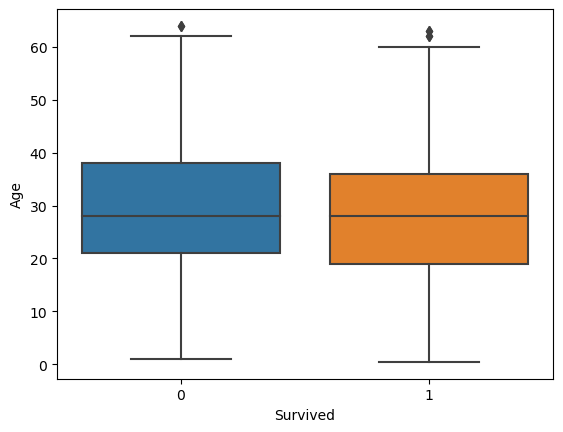

In [46]:
sns.boxplot(data = titanic_copy, y='Age', x = 'Survived' )

In [47]:
titanic_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 880 entries, 0 to 879
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  880 non-null    int64  
 1   Survived     880 non-null    int64  
 2   Pclass       880 non-null    int64  
 3   Name         880 non-null    object 
 4   Sex          880 non-null    object 
 5   Age          703 non-null    float64
 6   SibSp        880 non-null    int64  
 7   Parch        880 non-null    int64  
 8   Ticket       880 non-null    object 
 9   Fare         880 non-null    float64
 10  Cabin        880 non-null    int32  
 11  Embarked     878 non-null    object 
dtypes: float64(2), int32(1), int64(5), object(4)
memory usage: 79.2+ KB


In [48]:
titanic.shape

(891, 12)

### Check fare column

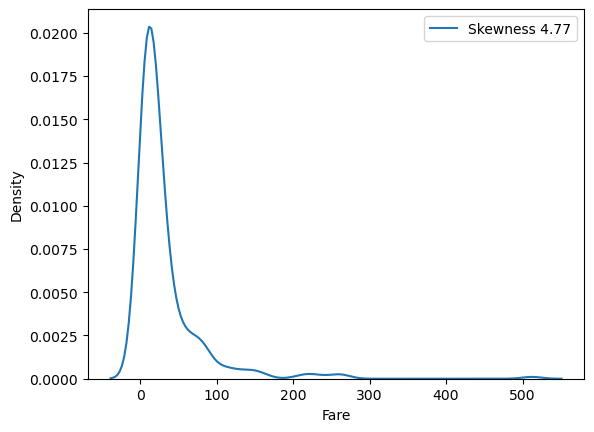

In [49]:
sns.kdeplot(data = titanic_copy['Fare'], label = 'Skewness %.2f'%(titanic_copy['Fare'].skew()))
plt.legend()

<Axes: xlabel='Survived', ylabel='Fare'>

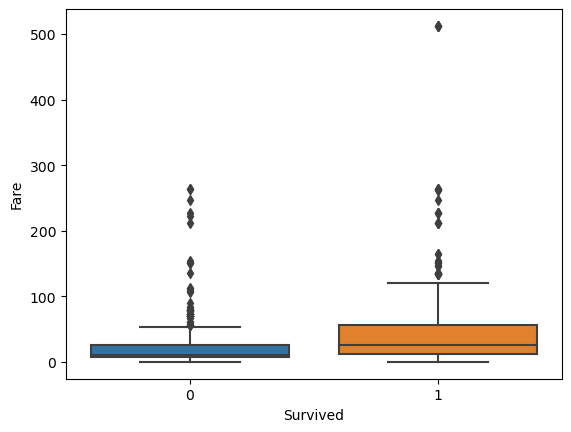

In [50]:
sns.boxplot(data=titanic_copy, x = "Survived", y= "Fare")

#### Above graph shows that there is one outlier.

In [51]:
titanic_copy.drop(index=titanic_copy['Fare'].idxmax(), inplace= True) # removing the highest value
titanic_copy['Fare'] = titanic_copy['Fare'].map(lambda x: np.log(x) if x > 0 else 0) #use log transformation to reduce the skewness

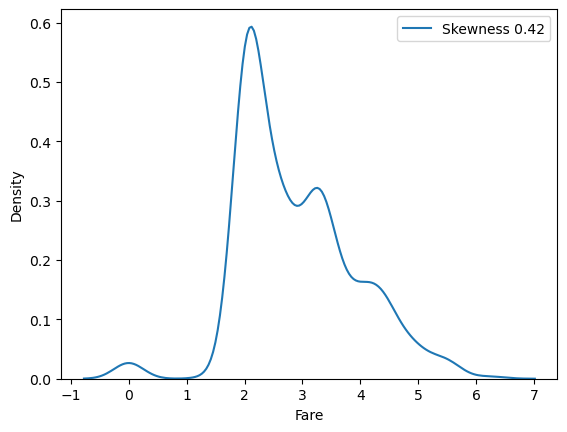

In [52]:
sns.kdeplot(data = titanic_copy['Fare'], label = 'Skewness %.2f'%(titanic_copy['Fare'].skew()))
plt.legend()

### Title Column
- Extracting the title from name column

In [53]:
titanic_copy['Title'] = [name.split(',')[1].split('.')[0].strip() for name in titanic_copy['Name']]

In [54]:
titanic_copy['Title'].value_counts()

Mr              507
Miss            181
Mrs             125
Master           40
Dr                7
Rev               6
Major             2
Mlle              2
Col               2
Don               1
Mme               1
Ms                1
Lady              1
Sir               1
the Countess      1
Jonkheer          1
Name: Title, dtype: int64

In [55]:
#replacing the Title which occure less number of times
titanic_copy['Title'] = titanic_copy['Title'].replace(['Dr','Rev','Major','Col',
                                                       'Don','Lady','Sir','the Countess','Jonkheer'], 'Rare')
titanic_copy['Title'] = titanic_copy['Title'].replace(['Mlle','Ms'], 'Miss')
titanic_copy['Title'] = titanic_copy['Title'].replace(['Mme'], 'Mrs')

In [56]:
titanic_copy['Title'].value_counts()

Mr        507
Miss      184
Mrs       126
Master     40
Rare       22
Name: Title, dtype: int64

In [57]:
titanic_copy[['Title','Survived']].groupby('Title', as_index= False).mean().sort_values(by ='Survived',ascending = False)

,Title,Survived
3,Mrs,0.793651
1,Miss,0.701087
0,Master,0.575000
4,Rare,0.363636
2,Mr,0.157791


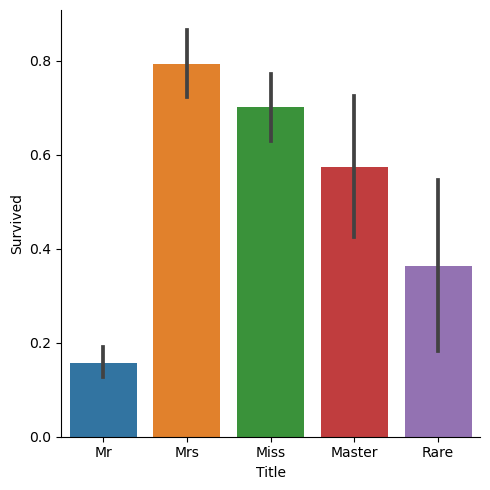

In [58]:
sns.catplot(x = 'Title', y = 'Survived', data = titanic_copy, kind = 'bar')

In [59]:
titanic_copy.drop(['PassengerId', 'Name', 'Ticket'], axis = 1, inplace= True)

In [60]:
titanic_copy.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title
0,0,3,male,22.0,1,0,1.981001,0,S,Mr
1,1,1,female,38.0,1,0,4.266662,1,C,Mrs
2,1,3,female,26.0,0,0,2.070022,0,S,Miss
3,1,1,female,35.0,1,0,3.972177,1,S,Mrs
4,0,3,male,35.0,0,0,2.085672,0,S,Mr


### IsAlone Column
- it will checked whether a passenger was alone(0) or travelling with family(1).

In [61]:
def isalone(df):
    """
    This fuction will create a column name IsAlone and verify whether a passanger was travelling alone or with family
    """
    df['Family'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = 0
    
    df.loc[df['Family']==1, 'IsAlone'] = 0
    df.loc[df['Family'] > 1, 'IsAlone'] = 1
    
    return df
    

In [62]:
titanic_copy = isalone(titanic_copy)

In [63]:
titanic_copy.drop(['SibSp', 'Parch', 'Family'], axis = 1, inplace=True)

In [64]:
titanic_copy.head()

,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,Title,IsAlone
0,0,3,male,22.0,1.981001,0,S,Mr,1
1,1,1,female,38.0,4.266662,1,C,Mrs,1
2,1,3,female,26.0,2.070022,0,S,Miss,0
3,1,1,female,35.0,3.972177,1,S,Mrs,1
4,0,3,male,35.0,2.085672,0,S,Mr,0


### Filling NaN values of Age Column

In [65]:
df_age_avg = titanic_copy.groupby(['Pclass', 'Sex', 'Survived', 'Title']).agg({'Age' : 'mean'}).reset_index()

In [66]:
df_age_avg['Concate'] = df_age_avg['Sex'] + df_age_avg['Title']

In [67]:
avg_age = {}
for i in range(df_age_avg.shape[0]):
    df_age_avg['Concate'][i] = df_age_avg['Concate'][i] + str(df_age_avg['Pclass'][i]) + str(df_age_avg['Survived'][i])
    avg_age[df_age_avg['Concate'][i]] = df_age_avg['Age'][i]

C:\Users\sayan\AppData\Local\Temp\ipykernel_14540\1866893911.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_age_avg['Concate'][i] = df_age_avg['Concate'][i] + str(df_age_avg['Pclass'][i]) + str(df_age_avg['Survived'][i])


In [68]:
avg_age

{'femaleMiss10': 26.0,
 'femaleMrs10': 25.0,
 'femaleMiss11': 29.795454545454547,
 'femaleMrs11': 40.85294117647059,
 'femaleRare11': 43.333333333333336,
 'maleMr10': 42.166666666666664,
 'maleRare10': 45.4,
 'maleMaster11': 5.306666666666667,
 'maleMr11': 35.96774193548387,
 'maleRare11': 47.8,
 'femaleMiss20': 31.0,
 'femaleMrs20': 38.5,
 'femaleMiss21': 22.016129032258064,
 'femaleMrs21': 33.16216216216216,
 'maleMr20': 31.5,
 'maleRare20': 42.0,
 'maleMaster21': 2.2588888888888885,
 'maleMr21': 36.666666666666664,
 'femaleMiss30': 17.81081081081081,
 'femaleMrs30': 36.166666666666664,
 'femaleMiss31': 14.171875,
 'femaleMrs31': 30.333333333333332,
 'maleMaster30': 5.4,
 'maleMr30': 28.271573604060915,
 'maleMaster31': 5.268888888888889,
 'maleMr31': 27.551724137931036}

In [69]:
try:
    titanic_copy.drop(['Concate'], axis=1, inplace=True)
except Exception as e:
    print(e)
titanic_copy.reset_index(drop=True, inplace=True)
titanic_copy['Concate'] = titanic_copy['Sex'] + titanic_copy['Title']
for i in range(titanic_copy.shape[0]):
    
    titanic_copy['Concate'][i] = titanic_copy['Concate'][i] + str(titanic_copy['Pclass'][i]) + str(titanic_copy['Survived'][i])
    if pd.isna(titanic_copy.loc[i, 'Age']):
        titanic_copy['Age'][i] = avg_age.get(titanic_copy['Concate'][i])

C:\Users\sayan\AppData\Local\Temp\ipykernel_14540\2572890239.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  titanic_copy['Concate'][i] = titanic_copy['Concate'][i] + str(titanic_copy['Pclass'][i]) + str(titanic_copy['Survived'][i])
C:\Users\sayan\AppData\Local\Temp\ipykernel_14540\2572890239.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  titanic_copy['Age'][i] = avg_age.get(titanic_copy['Concate'][i])


"['Concate'] not found in axis"


In [70]:
titanic_copy.drop(['Concate'], axis=1, inplace=True)

### Creating Age_group and Fare_group column

In [71]:
pd.cut(titanic_copy.Age, 5).value_counts(sort = True)

(25.852, 38.568]    349
(13.136, 25.852]    265
(38.568, 51.284]    144
(0.356, 13.136]      75
(51.284, 64.0]       46
Name: Age, dtype: int64

In [72]:
titanic_copy.loc[titanic_copy['Age']<=13.136 , 'Age'] = 0
titanic_copy.loc[(titanic_copy['Age']>13.136) & (titanic_copy['Age']<=25.852) , 'Age'] = 1
titanic_copy.loc[(titanic_copy['Age']>25.852) & (titanic_copy['Age']<=38.568) , 'Age'] = 2
titanic_copy.loc[(titanic_copy['Age']>38.568) & (titanic_copy['Age']<=51.284) , 'Age'] = 3
titanic_copy.loc[(titanic_copy['Age']>51.284) , 'Age'] = 4
titanic_copy['Age'] = titanic_copy['Age'].astype(int)

In [73]:
# grouping Fare column

titanic_copy['Fare_group'] = pd.cut(titanic_copy.Fare, 4)

In [74]:
titanic_copy['Fare_group'].value_counts(dropna=False)

(1.56, 3.119]       518
(3.119, 4.679]      295
(4.679, 6.239]       50
(-0.00624, 1.56]     16
Name: Fare_group, dtype: int64

In [75]:
titanic_copy.loc[titanic_copy['Fare']<=1.56 , 'Fare'] = 0
titanic_copy.loc[(titanic_copy['Fare']>1.56) & (titanic_copy['Fare']<=3.119) , 'Fare'] = 1
titanic_copy.loc[(titanic_copy['Fare']>3.119) & (titanic_copy['Fare']<=4.679) , 'Fare'] = 2
titanic_copy.loc[(titanic_copy['Fare']>4.679) , 'Fare'] = 3

In [76]:
titanic_copy['Fare'] = titanic_copy['Fare'].astype(int)

In [77]:
titanic_copy.drop(['Fare_group'], axis=1, inplace=True)

In [78]:
titanic_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879 entries, 0 to 878
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Survived  879 non-null    int64 
 1   Pclass    879 non-null    int64 
 2   Sex       879 non-null    object
 3   Age       879 non-null    int32 
 4   Fare      879 non-null    int32 
 5   Cabin     879 non-null    int32 
 6   Embarked  877 non-null    object
 7   Title     879 non-null    object
 8   IsAlone   879 non-null    int64 
dtypes: int32(3), int64(3), object(3)
memory usage: 51.6+ KB


### Creating new attribute 
 - age*class
 - Fare*class
 - IsAlone*class

In [79]:
titanic_copy['age*class'] = titanic_copy['Age'] * titanic_copy['Pclass']
titanic_copy['Fare*class'] = titanic_copy['Fare'] * titanic_copy['Pclass']
titanic_copy['IsALone*class'] = titanic_copy['IsAlone'] * titanic_copy['Pclass']
titanic_copy['Cabin*class'] = titanic_copy['Cabin'] * titanic_copy['Pclass']

In [80]:
titanic_copy.drop(['Age','Fare','IsAlone', 'Cabin'], axis = 1, inplace= True)

In [81]:
titanic_copy.corr()

C:\Users\sayan\AppData\Local\Temp\ipykernel_14540\1860123354.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  titanic_copy.corr()


,Survived,Pclass,age*class,Fare*class,IsALone*class,Cabin*class
Survived,1.000000,-0.345117,-0.308257,-0.120838,0.065756,0.280593
Pclass,-0.345117,1.000000,0.382690,0.451732,0.174557,-0.512683
age*class,-0.308257,0.382690,1.000000,0.026190,-0.181919,-0.256275
Fare*class,-0.120838,0.451732,0.026190,1.000000,0.496542,-0.255731
IsALone*class,0.065756,0.174557,-0.181919,0.496542,1.000000,-0.049454
Cabin*class,0.280593,-0.512683,-0.256275,-0.255731,-0.049454,1.000000


In [82]:
# All null columns are numerical but EEmbarked is categorical. Will handle categorical null value
most_embarked = titanic_copy['Embarked'].mode()[0]

titanic_copy['Embarked'].fillna(most_embarked, inplace=True)

In [83]:
titanic_copy['Embarked'].value_counts(dropna=False)

S    640
C    164
Q     75
Name: Embarked, dtype: int64

In [84]:
titanic_copy.drop(['Embarked'], axis=1, inplace=True)

### Train Test split
- Stratified ShuffleSplit to get Sex, Pclass a proper distribution

In [85]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits = 1, test_size = .2, random_state = 42)
for train_index, test_index in split.split(titanic_copy,titanic_copy[['Sex', 'Pclass']]):
    X_train, X_test = titanic_copy.drop('Survived', axis = 1).iloc[train_index], titanic_copy.drop('Survived', axis = 1).iloc[test_index]
    y_train, y_test = titanic_copy['Survived'].iloc[train_index], titanic_copy['Survived'].iloc[test_index]

In [86]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 703 entries, 452 to 455
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Pclass         703 non-null    int64 
 1   Sex            703 non-null    object
 2   Title          703 non-null    object
 3   age*class      703 non-null    int64 
 4   Fare*class     703 non-null    int64 
 5   IsALone*class  703 non-null    int64 
 6   Cabin*class    703 non-null    int64 
dtypes: int64(5), object(2)
memory usage: 43.9+ KB


In [87]:
X_test.shape

(176, 7)

### Using custom function dataprep to create X_tran_prep and y_train_prep

In [88]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer



def dataprep (df):
    df_num = df.drop(['Sex','Title'], axis = 1)
    num_attribs = list (df_num)
    cat_attribute = ['Sex', 'Title']
    num_pipeline = Pipeline([ 
                            ('impute', SimpleImputer(strategy = "median")),
                            ('std_scaler', StandardScaler())
                    ])
    full_pipeline = ColumnTransformer ([
        ("num",num_pipeline, num_attribs),
        ("cat",OneHotEncoder(),cat_attribute)
    ])
    
    df_prepared = full_pipeline.fit_transform(df)
    return df_prepared


X_train_prepared = dataprep(X_train)
X_test_prepared = dataprep(X_test)

In [89]:
X_train_prepared[0]

array([ 0.82097234,  0.89677447,  0.01545296, -0.72808051, -0.48634208,
        0.        ,  1.        ,  0.        ,  0.        ,  1.        ,
        0.        ,  0.        ])

In [90]:
X_test_prepared[0]

array([ 0.81831709, -0.3535977 ,  2.70049009,  1.83098623, -0.47195004,
        1.        ,  0.        ,  0.        ,  1.        ,  0.        ,
        0.        ,  0.        ])

## Function to generate model prediction and accurecy score

In [91]:
accurecy_dict = {}
model_list = []
def model_fit_pred(model_name, model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accurecy(y_test, y_pred,model_name)
    model_list.append(model)

def accurecy(y_test, y_pred, model_name):
    from sklearn import metrics
    pred = metrics.accuracy_score(y_test, y_pred)
    accurecy_dict[model_name] = pred
    print(f'Accurecy of the {model_name} is:  ', pred)

## Model training and fitting
- K Nearest neighbour
- Random forest
- Linear Regression
- SVM
- Decision Tree
- Gaussian naive bayes
- perceptron
- linear SVC
- SGD Classifier 

In [92]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

knn = KNeighborsClassifier(n_neighbors=5)
clf = RandomForestClassifier(n_estimators = 100) 
lreg = LogisticRegression()
svc = SVC()
dclf = DecisionTreeClassifier()
gnb = GaussianNB()
perc = Perceptron()
lsvc = LinearSVC()
sgd = SGDClassifier()

model_fit_pred('KNN', knn, X_train_prepared,X_test_prepared, y_train, y_test)
model_fit_pred('Random Forest', clf, X_train_prepared,X_test_prepared, y_train, y_test)
model_fit_pred('Logestic Regression', lreg, X_train_prepared,X_test_prepared, y_train, y_test)
model_fit_pred('SVC', svc, X_train_prepared,X_test_prepared, y_train, y_test)
model_fit_pred('Decision Tree', dclf, X_train_prepared,X_test_prepared, y_train, y_test)
model_fit_pred('Gaussion NB', gnb, X_train_prepared,X_test_prepared, y_train, y_test)
model_fit_pred('Perceptron', perc, X_train_prepared,X_test_prepared, y_train, y_test)
model_fit_pred('Linear SVC', lsvc, X_train_prepared,X_test_prepared, y_train, y_test)
model_fit_pred('SGD Classifier', sgd, X_train_prepared,X_test_prepared, y_train, y_test)



Accurecy of the KNN is:   0.8011363636363636
Accurecy of the Random Forest is:   0.8125
Accurecy of the Logestic Regression is:   0.7897727272727273
Accurecy of the SVC is:   0.7954545454545454
Accurecy of the Decision Tree is:   0.8125
Accurecy of the Gaussion NB is:   0.7329545454545454
Accurecy of the Perceptron is:   0.6818181818181818
Accurecy of the Linear SVC is:   0.7954545454545454
Accurecy of the SGD Classifier is:   0.7443181818181818


Text(0.5, 1.0, 'MODEL ACCURECY SCORE')

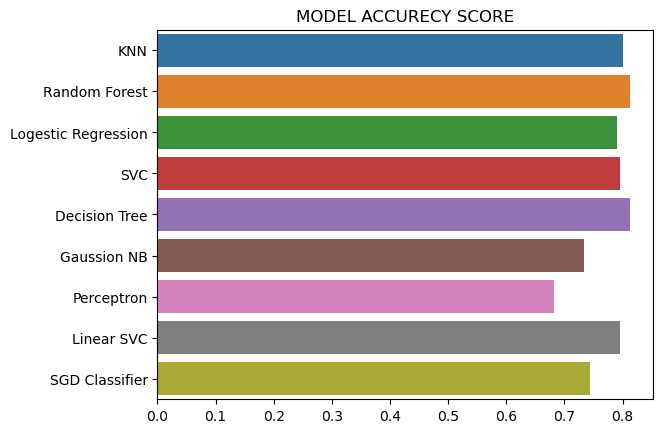

In [93]:
y = list(accurecy_dict.keys())
x = [accurecy_dict.get(i) for i in y]
sns.barplot(x= x, y = y, orient='h')
plt.title("MODEL ACCURECY SCORE")

# USing corss val score

In [94]:
from sklearn.model_selection import cross_val_score, cross_val_predict
scores = []
def cv_score(model_list, X_train_prepared, y_train):
    for model in model_list:
        score = cross_val_score(model, X_train_prepared, y_train,
                         scoring="accuracy", cv=10)
        scores.append(score)
    return scores

In [95]:
cv_results = cv_score(model_list, X_train_prepared, y_train)

C:\Users\sayan\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\sayan\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\sayan\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [96]:
#calculating mean and std of each model CV score
cv_mean = [result.mean() for result in cv_results]
cv_std = [result.std() for result in cv_results]

In [97]:
model_name = [str(model)[:len(str(model))-2] for model in model_list]

In [98]:
print('MODEL NAME =========================> MEAN')
for i in range(len(model_name)):
    print(f'{model_name[i]} ====>       {cv_mean[i]}')

print('==='*20)
highest_mean = sorted(zip(cv_mean, model_name), reverse=True)[0]
print(highest_mean)

MODEL NAME =========================> MEAN
KNeighborsClassifier ====>       0.8235010060362173
RandomForestClassifier ====>       0.8406639839034206
LogisticRegression ====>       0.8278068410462776
SVC ====>       0.8434607645875252
DecisionTreeClassifier ====>       0.8292957746478873
GaussianNB ====>       0.7863782696177062
Perceptron ====>       0.7908048289738431
LinearSVC ====>       0.8277867203219316
SGDClassifier ====>       0.7328370221327967
(0.8434607645875252, 'SVC')


<Axes: >

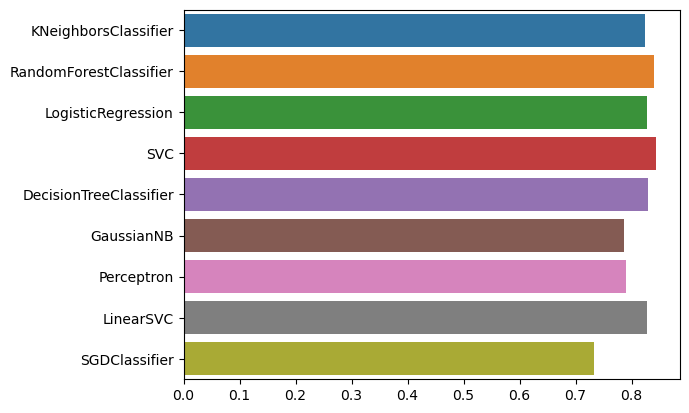

In [99]:
#baeplot for mean value
sns.barplot(x = cv_mean, y = model_name, orient='h',)

- As per above graph SVC got highest mean

In [100]:
#using SVC to get the confusion matrix
def cv_predict(model_list, X_test_prepared, y_test):
    for model in model_list:
        y_pred = cross_val_predict(model, X_test_prepared, y_test, cv=10)
        confusion_metric = metrics.confusion_matrix(y_test, y_pred)
        model_name = str(model)[:len(str(model))-2]
        plt.figure()
        sns.heatmap(confusion_metric, annot= True, cmap= 'Blues')
        plt.title(model_name)

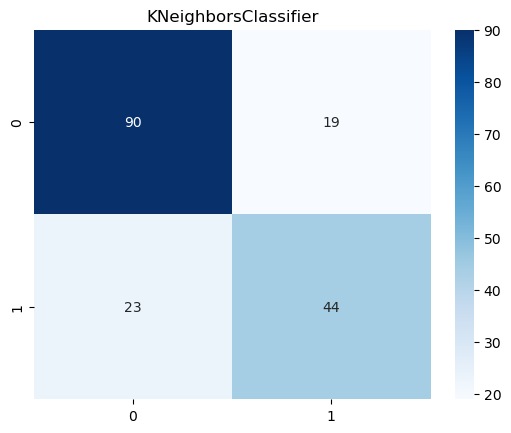

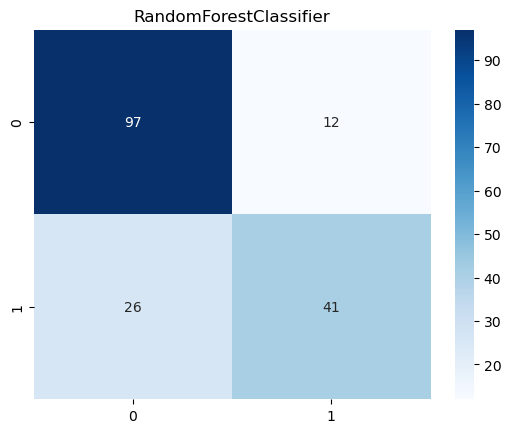

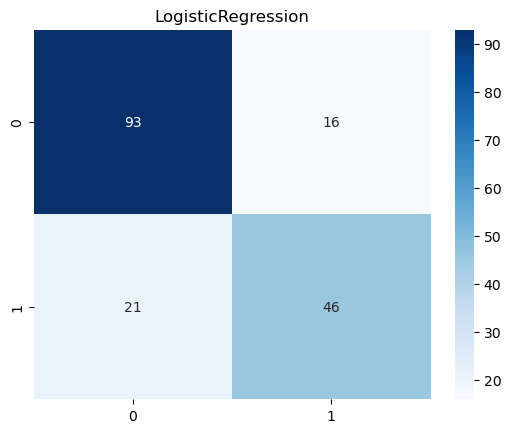

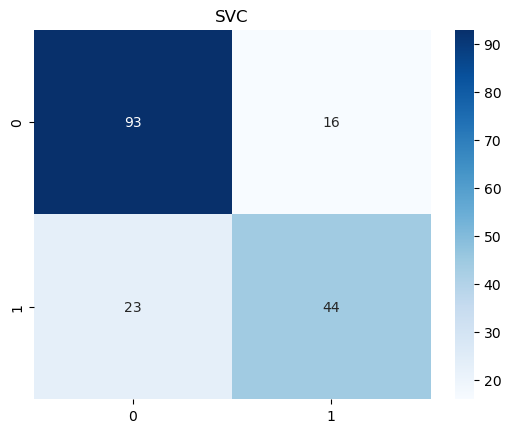

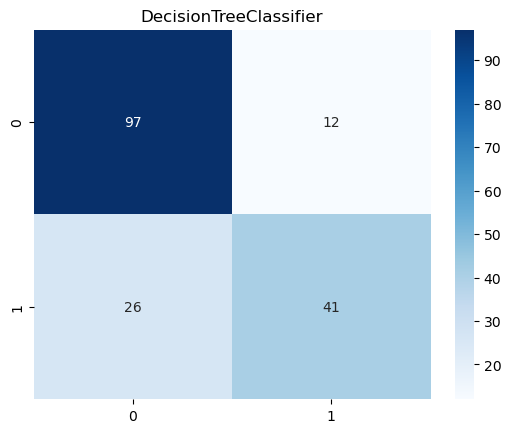

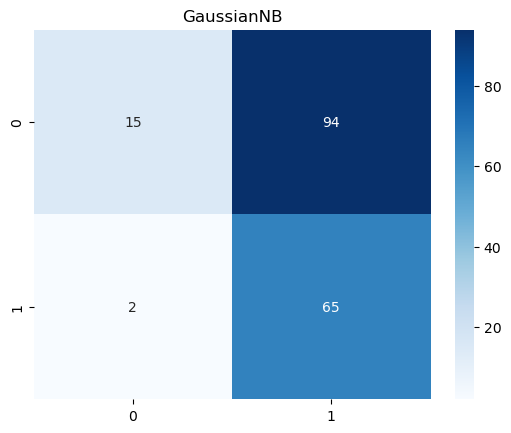

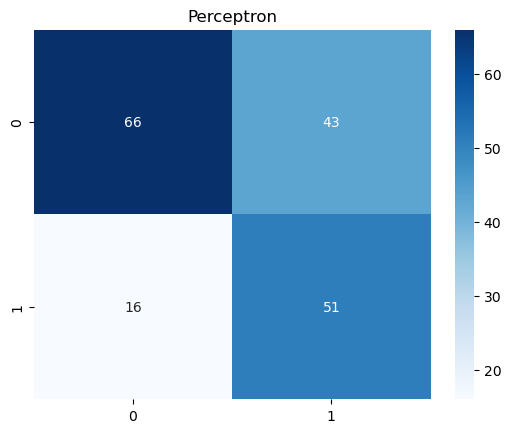

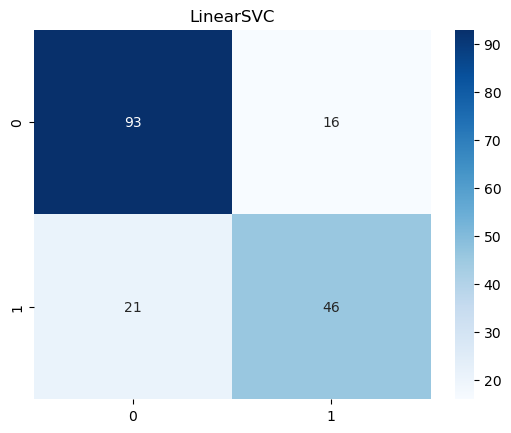

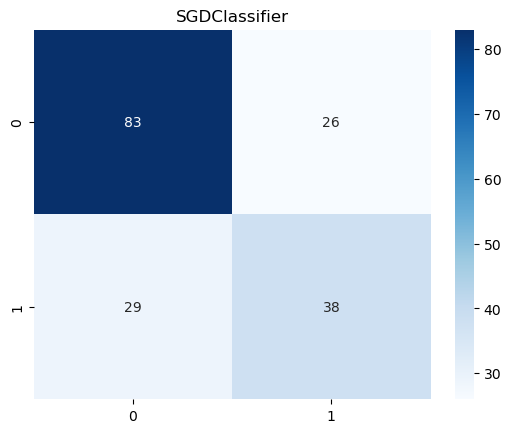

In [101]:
cv_predict(model_list, X_test_prepared, y_test)

## Hyper parameter tuning for SVC

In [102]:
from sklearn.model_selection import GridSearchCV
try:
    param_grid = {'C' : [100, 1000, 10000, 100000],
                  "gamma" : [.01, .001, .0001, .00001, .000001],
                 'kernel' : ['rbf']}
    grid_search = GridSearchCV(model_list[model_name.index(highest_mean[1])], param_grid, cv = 10,
                              scoring='accuracy', return_train_score=True)
    grid_search.fit(X_train_prepared, y_train)
except Exception as e:
    print(highest_mean[1], e)
    
grid_search

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': [100, 1000, 10000, 100000],
                         'gamma': [0.01, 0.001, 0.0001, 1e-05, 1e-06],
                         'kernel': ['rbf']},
             return_train_score=True, scoring='accuracy')

In [103]:
final_model = grid_search.best_estimator_

In [104]:
y_pred = final_model.predict(X_test_prepared)

[[92 17]
 [19 48]]
Accurecy score:  0.7954545454545454


<Axes: >

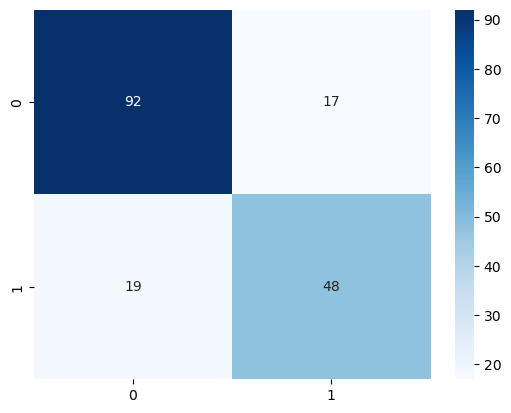

In [105]:
confusion_metric = metrics.confusion_matrix(y_test, y_pred)
print(confusion_metric)
print('Accurecy score: ', metrics.accuracy_score(y_test, y_pred))
sns.heatmap(confusion_metric, annot= True, cmap= 'Blues', fmt='g')

### Class for Data preperation

In [107]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedShuffleSplit

def outliers(df, params:[]):
    """
    This fuction will detect and remove the outliers where it is more than Q3 and less than Q1 by 1.5times of IQR.

    """
    df = df.copy()
    for param in params:
        Q1 = df[param].quantile(.25)
        Q3 = df[param].quantile(.75)

        IQR = Q3 - Q1
        upper = Q3 + 1.5*IQR
        lower = Q1 - 1.5*IQR

        upper_arr = np.where(df[param] >= upper)[0]
        lower_arr = np.where(df[param] <= lower)[0]
        df = df.drop(index=upper_arr)
        df = df.drop(index=lower_arr)
        df = df.reset_index()
        df = df.drop('index',axis = 1)

    return df

# Train test spliing
def trainTestsplit (df):
    split = StratifiedShuffleSplit(n_splits = 1, test_size = .2, random_state = 42)
    for train_index, test_index in split.split(titanic_copy,titanic_copy[['Sex', 'Pclass']]):
        X_train, X_test = titanic_copy.drop('Survived', axis = 1).iloc[train_index], titanic_copy.drop('Survived', axis = 1).iloc[test_index]
        X_train, X_test = titanic_copy['Survived'].iloc[train_index], titanic_copy['Survived'].iloc[test_index]
    return X_train, X_test, X_train, X_test

class DataPreparationPipeline(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X['Fare'] = X['Fare'].map(lambda x: np.log(x) if x > 0 else 0) # log trasformation on fare column
        X['Title'] = [name.split(',')[1].split('.')[0].strip() for name in X['Name']] #creating new column 'Title'
        #replacing the Title which occure less number of times
        X['Title'] = X['Title'].replace(['Dr','Rev','Major','Col',
                                         'Don','Lady','Sir','the Countess','Jonkheer', 'Dona'], 'Rare')
        X['Title'] = X['Title'].replace(['Mlle','Ms'], 'Miss')
        X['Title'] = X['Title'].replace(['Mme'], 'Mrs')
        # There is no patern to understand the NaN values of the Cabin. Thus we will fill 0 for NaN and if Cabin is present we will mark as 1
        X.loc[X['Cabin'].isna() == False, 'Cabin'] = 1
        X.loc[X['Cabin'].isna() == True, 'Cabin'] = 0
        X['Cabin'] = X['Cabin'].astype(int)
        #Creating new column isAlone.
        X['Family'] = X['SibSp'] + X['Parch'] + 1
        X['IsAlone'] = 0
        X.loc[X['Family']==1, 'IsAlone'] = 0
        X.loc[X['Family'] > 1, 'IsAlone'] = 1
        
        #filling NaN values for age column
        if X['Age'].isna().sum() > 0:
            df_age_avg = X.groupby(['Pclass', 'Sex', 'Title']).agg({'Age' : 'mean'}).reset_index()
            df_age_avg['Concate'] = df_age_avg['Sex'] + df_age_avg['Title']
            avg_age = {}
            for i in range(df_age_avg.shape[0]):
                df_age_avg['Concate'][i] = df_age_avg['Concate'][i] + str(df_age_avg['Pclass'][i])
                avg_age[df_age_avg['Concate'][i]] = df_age_avg['Age'][i]
            X.reset_index(drop=True, inplace=True)
            X['Concate'] = X['Sex'] + X['Title']
            for i in range(X.shape[0]):
                X['Concate'][i] = X['Concate'][i] + str(X['Pclass'][i])
                if pd.isna(X.loc[i, 'Age']):
                    X['Age'][i] = avg_age.get(X['Concate'][i])
        
        #Age Group
        X.loc[X['Age']<=13.136 , 'Age'] = 0
        X.loc[(X['Age']>13.136) & (X['Age']<=25.852) , 'Age'] = 1
        X.loc[(X['Age']>25.852) & (X['Age']<=38.568) , 'Age'] = 2
        X.loc[(X['Age']>38.568) & (X['Age']<=51.284) , 'Age'] = 3
        X.loc[(X['Age']>51.284) , 'Age'] = 4
        X['Age'] = X['Age'].astype(int)
        
        #Fare Gruop
        X.loc[X['Fare']<=1.56 , 'Fare'] = 0
        X.loc[(X['Fare']>1.56) & (X['Fare']<=3.119) , 'Fare'] = 1
        X.loc[(X['Fare']>3.119) & (X['Fare']<=4.679) , 'Fare'] = 2
        X.loc[(X['Fare']>4.679) , 'Fare'] = 3
        X['Fare'] = X['Fare'].astype(int)
        
        # Creating new attribute
        X['age*class'] = X['Age'] * X['Pclass']
        X['Fare*class'] = X['Fare'] * X['Pclass']
        X['IsALone*class'] = X['IsAlone'] * X['Pclass']
        X['Cabin*class'] = X['Cabin'] * X['Pclass']
        
        #Droping columns
        X.drop(['Concate','Age','Fare','IsAlone', 'Cabin', 
                'SibSp', 'Parch', 'Family', 'PassengerId', 'Name', 
                'Ticket','Age','Fare','IsAlone', 'Cabin', 'Embarked'], axis = 1, inplace= True)
        return X

def dataprep (df):
    df_num = df.drop(['Sex','Title'], axis = 1)
    num_attribs = list (df_num)
    cat_attribute = ['Sex', 'Title']
    num_pipeline = Pipeline([ 
                            ('impute', SimpleImputer(strategy = "median")),
                            ('std_scaler', StandardScaler())
                    ])
    full_pipeline = ColumnTransformer ([
        ("num",num_pipeline, num_attribs),
        ("cat",OneHotEncoder(),cat_attribute)
    ])
    
    df_prepared = full_pipeline.fit_transform(df)
    return df_prepared  

In [108]:
titanic_df = outliers(titanic, ['Age'])

In [109]:
data_prep = DataPreparationPipeline()
X = data_prep.fit_transform(titanic_df)

C:\Users\sayan\AppData\Local\Temp\ipykernel_14540\2670576304.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_age_avg['Concate'][i] = df_age_avg['Concate'][i] + str(df_age_avg['Pclass'][i])
C:\Users\sayan\AppData\Local\Temp\ipykernel_14540\2670576304.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Concate'][i] = X['Concate'][i] + str(X['Pclass'][i])
C:\Users\sayan\AppData\Local\Temp\ipykernel_14540\2670576304.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

In [110]:
X_prep, y_prep = X.drop(['Survived'], axis = 1), X['Survived']

In [111]:
X_prepared = dataprep(X_prep)

In [112]:
grid_search.fit(X_prepared, y_prep)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': [100, 1000, 10000, 100000],
                         'gamma': [0.01, 0.001, 0.0001, 1e-05, 1e-06],
                         'kernel': ['rbf']},
             return_train_score=True, scoring='accuracy')

In [113]:
titanic_test = pd.read_csv('./dataset/test.csv')

In [114]:
passenger_id = titanic_test['PassengerId'].values

In [115]:
gender_sub_df = pd.read_csv('./dataset/gender_submission.csv')

In [116]:
gender_sub_df.set_index(keys='PassengerId', inplace=True)

In [117]:
y_test_final = gender_sub_df.loc[passenger_id, 'Survived']

In [118]:
X_test = data_prep.fit_transform(titanic_test)

C:\Users\sayan\AppData\Local\Temp\ipykernel_14540\2670576304.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_age_avg['Concate'][i] = df_age_avg['Concate'][i] + str(df_age_avg['Pclass'][i])
C:\Users\sayan\AppData\Local\Temp\ipykernel_14540\2670576304.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Concate'][i] = X['Concate'][i] + str(X['Pclass'][i])
C:\Users\sayan\AppData\Local\Temp\ipykernel_14540\2670576304.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

In [119]:
X_test_prepared = dataprep(X_test)

In [120]:
pd.DataFrame(X_test_prepared).head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.873482,1.064126,0.134137,-0.711711,-0.479074,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.873482,2.492836,0.134137,1.882723,-0.479074,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.315819,2.016599,-0.944115,-0.711711,-0.479074,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0.873482,1.064126,0.134137,-0.711711,-0.479074,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.873482,-0.364583,0.134137,1.882723,-0.479074,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [121]:
X_test['Title'].value_counts(dropna=False)

Mr        240
Miss       79
Mrs        72
Master     21
Rare        6
Name: Title, dtype: int64

In [122]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Pclass         418 non-null    int64 
 1   Sex            418 non-null    object
 2   Title          418 non-null    object
 3   age*class      418 non-null    int64 
 4   Fare*class     418 non-null    int64 
 5   IsALone*class  418 non-null    int64 
 6   Cabin*class    418 non-null    int64 
dtypes: int64(5), object(2)
memory usage: 23.0+ KB


In [123]:
final_model = grid_search.best_estimator_

In [124]:
y_test_pred = final_model.predict(X_test_prepared)

[[250  16]
 [ 11 141]]
Accurecy score:  0.9354066985645934


<Axes: >

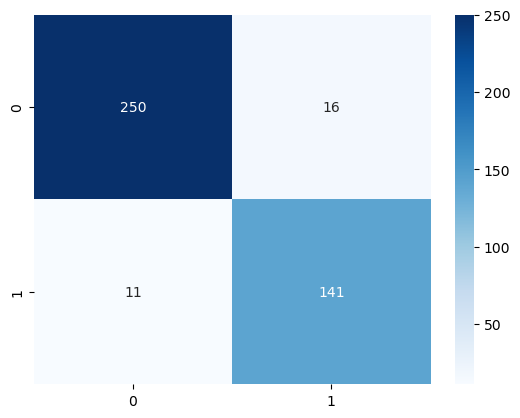

In [125]:
confusion_metric = metrics.confusion_matrix(y_test_final, y_test_pred)
print(confusion_metric)
print('Accurecy score: ', metrics.accuracy_score(y_test_final, y_test_pred))
sns.heatmap(confusion_metric, annot= True, cmap= 'Blues', fmt='g')

### Preparing the data for submission

In [126]:
test_df = pd.read_csv('./dataset/test.csv')

In [127]:
submit_df = pd.DataFrame({'PassengerID' : test_df['PassengerId'], 'Survived' : y_test_pred})

In [128]:
submit_df.shape

(418, 2)

In [129]:
submit_df

,PassengerID,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [130]:
# Save the file in csv
submit_df.to_csv('./submission/submit.csv',index=False)